<a href="https://colab.research.google.com/github/yuchun-nii/something-interesting/blob/main/ResNet50_grad-CAM_and_grad-CAM%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import backend as K
from keras import models
import skimage.io
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np

In [ ]:
#印出tensor的形狀、最大最小值
def tensor_summary(tensor):
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

#Takes a tensor of 3 dimensions (height, width, colors)
#將值normalize到[0,1]
def normalize(image):
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)

def display_img(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
#images: A list of images.(圖片列表)
#ndarray:Numpy數組的列表,每個數組代表一個圖像。
#concatenate array(images):Numpy數組列表的列表(清單)。在這種情況下，內部列表中的圖像將合併為一張圖像。
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    #用zip同時迭代images跟titles，每個元素以一對一的方式配對起來/zip對不同長度的以短的為準
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")#關閉軸

        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

def read_layer(model, x, layer_name):
    #返回指定層激活值
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]

#輸出特定層的權重跟捲積出的圖片    
def view_layer(model, x, layer_name, cols=5):
    print(layer_name)
    outputs = read_layer(model, x, layer_name)
    display_img([outputs[:,:,i] for i in range(20)], cols=cols)
    plt.show()

In [ ]:
model = ResNet50(weights='imagenet')#載入Keras預訓練好的權重
model.summary()#顯示模型結構，主要是用來確認layer的名稱，方便之後看feature map的時候用

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

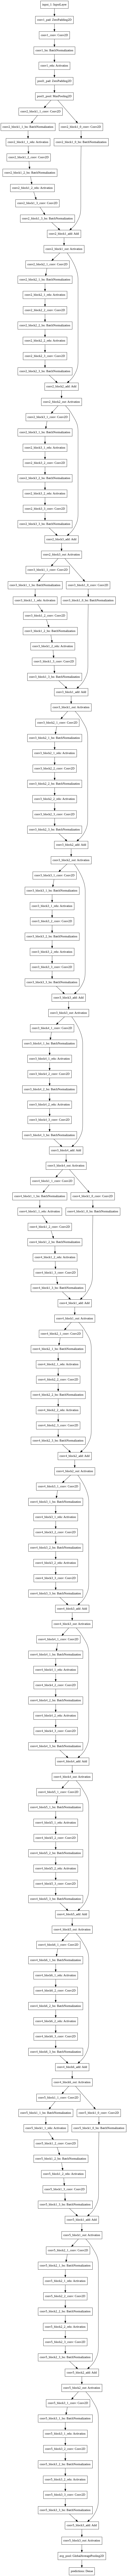

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

shape: (224, 224, 3)  min: 0  max: 255


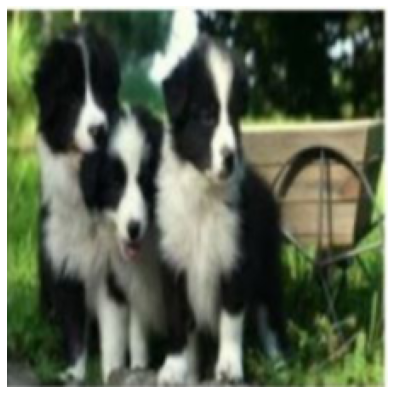

In [ ]:
dim=224
#image = skimage.io.imread("http://lorempixel.com/224/224/animals/")# 從網路隨機挑一個224x224的圖片來測試模型
image=skimage.io.imread("dog.JPG")
image = cv2.resize(image, (dim, dim), interpolation=cv2.INTER_AREA)
tensor_summary(image)
display_img([image], cols=2)

In [ ]:
x = image.astype(np.float32)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
tensor_summary(x)

shape: (1, 224, 224, 3)  min: -123.68000030517578  max: 151.06100463867188


shape: (7, 7, 3, 64)  min: -0.6710243821144104  max: 0.7043237686157227


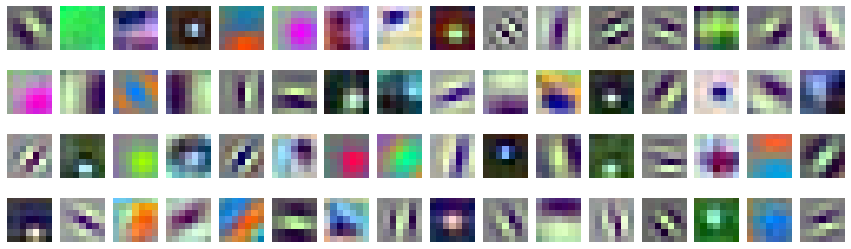

In [ ]:
weights = model.get_layer("conv1_conv").get_weights()[0]
tensor_summary(weights)
display_img([weights[:,:,::-1,i] for i in range(weights.shape[3])], cols=16, interpolation="none")
plt.show()

conv1_conv
shape: (1, 112, 112, 64)  min: -1173.3714599609375  max: 1216.12255859375


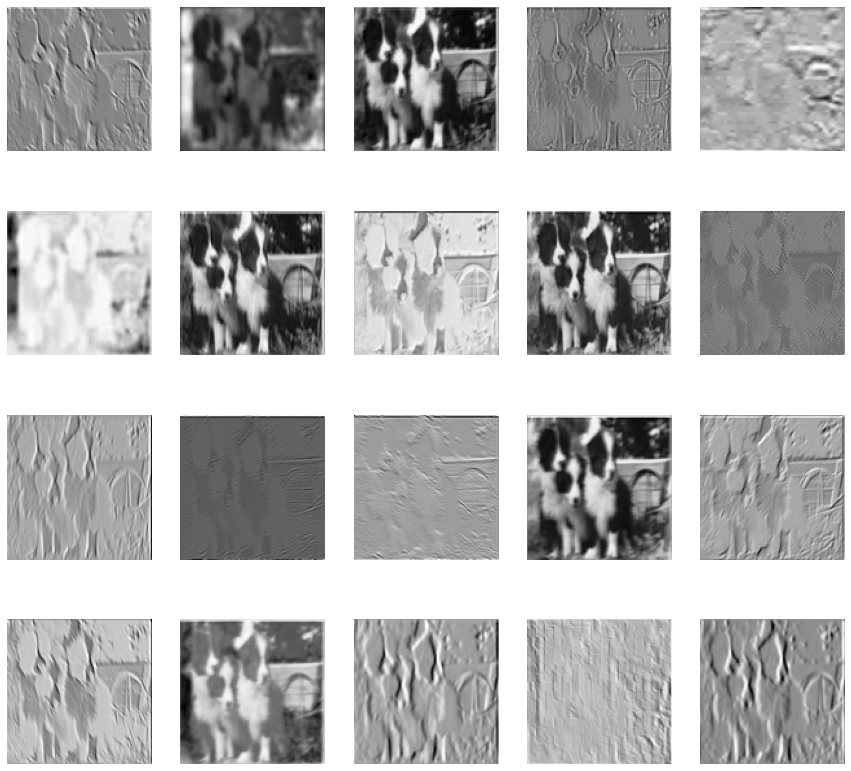

In [ ]:
view_layer(model, x, "conv1_conv")

conv2_block1_1_conv
shape: (1, 56, 56, 64)  min: -13.485845565795898  max: 16.9591007232666


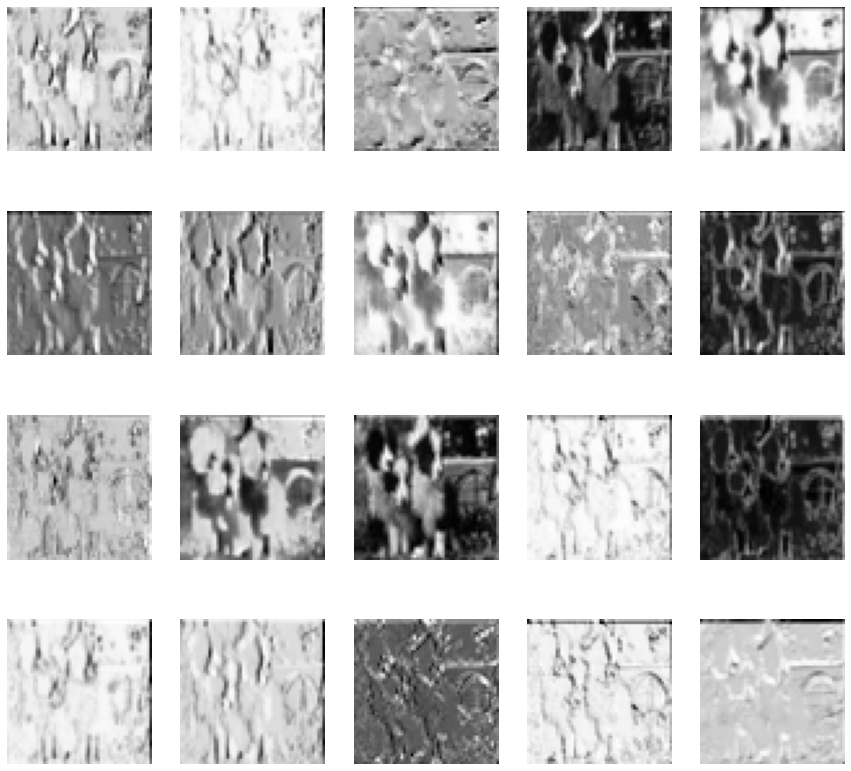

In [ ]:
view_layer(model, x, "conv2_block1_1_conv")

conv2_block2_1_conv
shape: (1, 56, 56, 64)  min: -8.36805534362793  max: 5.374776840209961


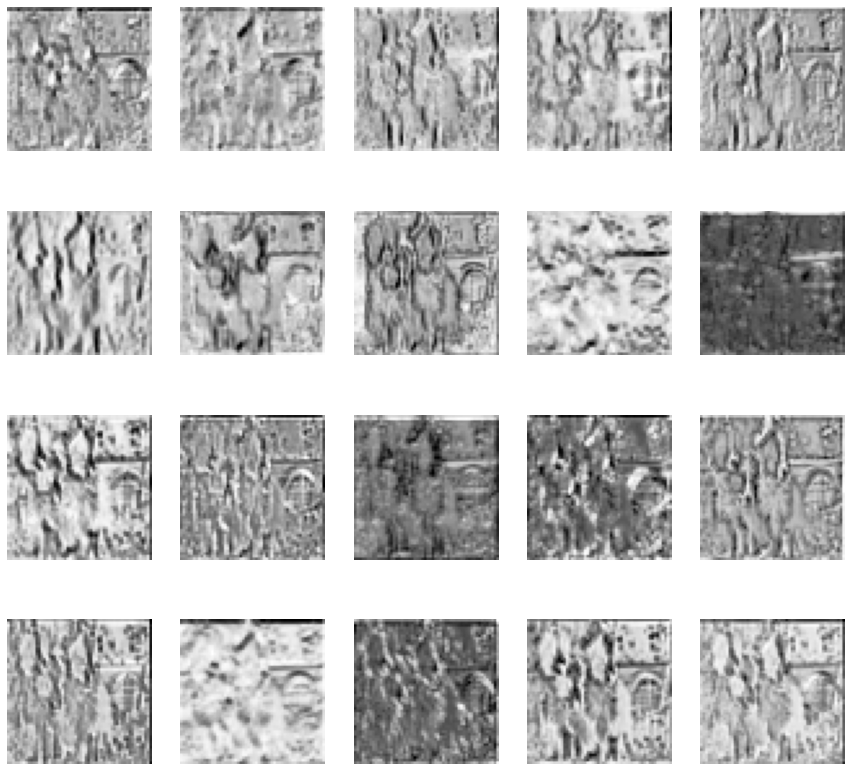

In [ ]:
view_layer(model, x, "conv2_block2_1_conv")

conv3_block1_1_conv
shape: (1, 28, 28, 128)  min: -6.648393630981445  max: 4.9182634353637695


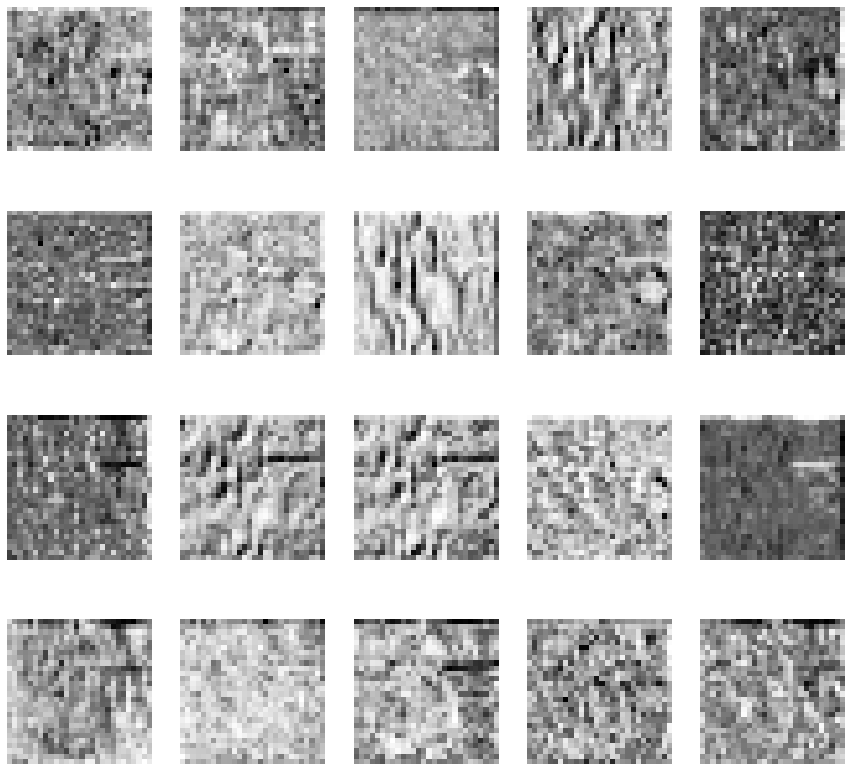

In [ ]:
view_layer(model, x, "conv3_block1_1_conv")

conv4_block1_1_conv
shape: (1, 14, 14, 256)  min: -5.505341529846191  max: 5.4362592697143555


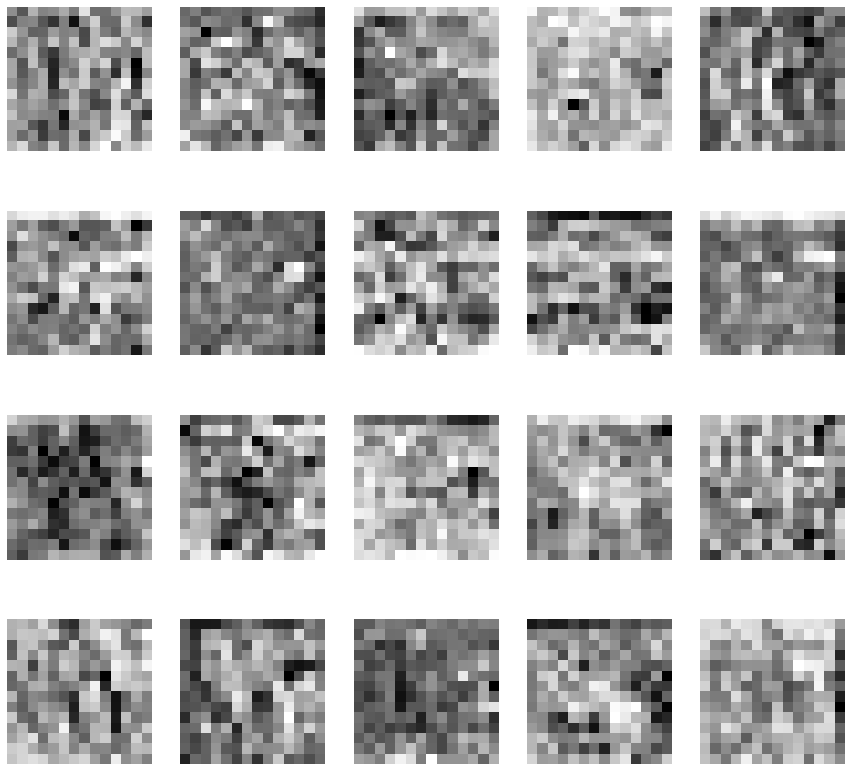

In [ ]:
view_layer(model, x, "conv4_block1_1_conv")

conv5_block1_1_conv
shape: (1, 7, 7, 512)  min: -5.186872482299805  max: 4.264251708984375


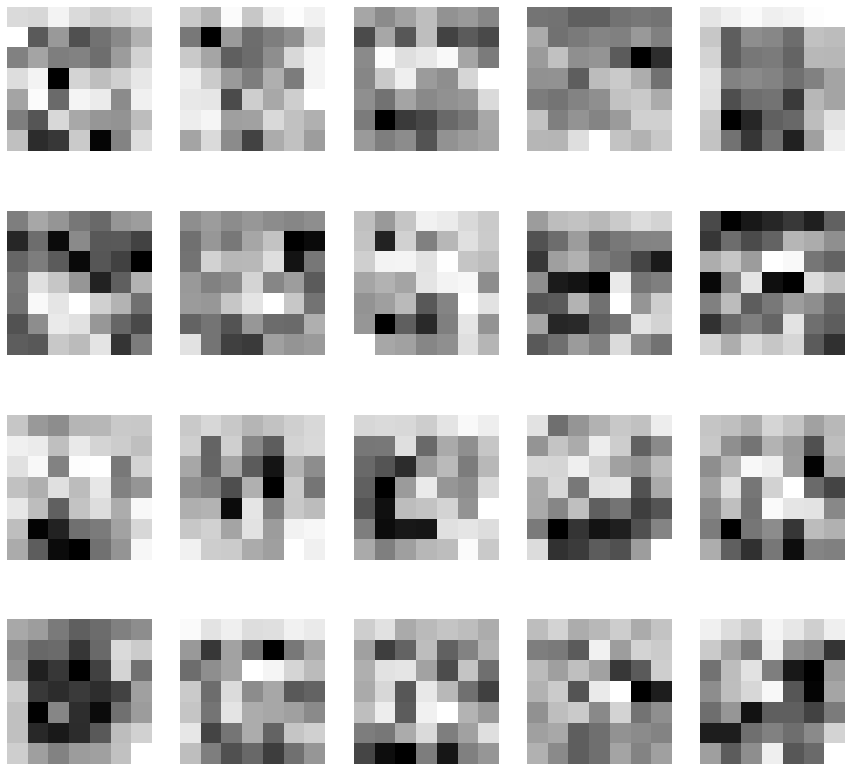

In [ ]:
view_layer(model, x, "conv5_block1_1_conv")

conv5_block3_add
shape: (1, 7, 7, 2048)  min: -14.773574829101562  max: 39.45518112182617


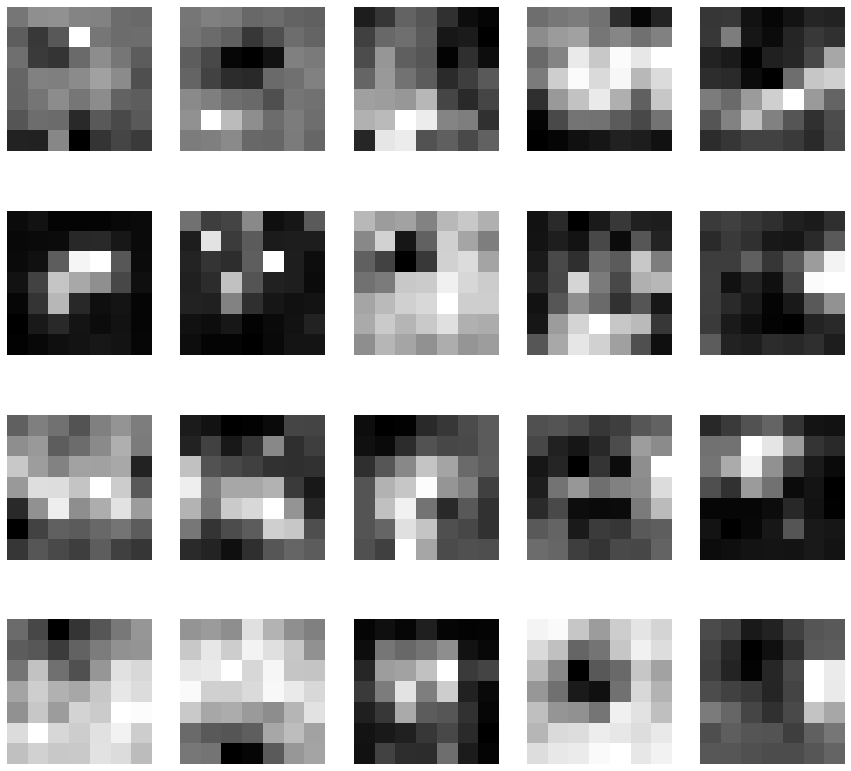

In [ ]:
view_layer(model, x, "conv5_block3_add")

In [ ]:
predictions = model.predict(x)#預測圖片

#找到最大值對應的標籤
label_index = np.argmax(predictions)
print("label index: ", label_index)

#顯示預測前三
decode_predictions(predictions,top=3)

label index:  331


[[('n02326432', 'hare', 0.57061666),
  ('n02106166', 'Border_collie', 0.21250097),
  ('n02106030', 'collie', 0.036062054)]]

shape: (1, 1000)  min: 2.0671260259064184e-08  max: 0.5706166625022888


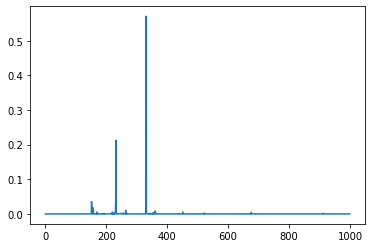

In [ ]:
# 預測值長條圖
plt.plot(read_layer(model, x, "predictions"))
plt.show()

In [ ]:
from google.colab.patches import cv2_imshow #cv2.imshow在Colab上不起作用，改用cv2_imshow

def Grad_CAM(orig,layer_name='conv5_block3_out', intensity=0.5, res=250):
  img=skimage.io.imread(orig)
  img = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_NEAREST)

  x = img.astype(np.float32)
  x = np.expand_dims(x, 0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) #印出圖片的預測

#定義一個tf.GradientTape，以便計算梯度（這是tf.2中的用法，tf.1直接用K.gradient就可以了)
  with tf.GradientTape() as tape:
    conv_layer = model.get_layer(layer_name)#最後一個卷積層
    iterate = models.Model([model.inputs], [model.output, conv_layer.output])#列表:(圖像,模型輸出&最終一個卷積層)
    model_out, conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, conv_layer)#預測輸出和最後一個捲積的梯度
    pooled_grads = K.mean(grads, axis=(0, 1, 2))#在所有軸間求平均
    #pooled_grads=w
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_layer), axis=-1)
  
  #可視化熱圖
  
  heatmap = np.maximum(heatmap, 0)#ReLU
  #normalize
  max_heat = np.max(heatmap)
  if max_heat == 0:
      max_heat = 1e-10
  heatmap /= max_heat
  heatmap=np.squeeze(heatmap)
  plt.matshow(heatmap)
  plt.show()
  

  #結合熱圖跟用來預測的圖片
  img = cv2.imread(orig)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  #im2=cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))#原圖
  im3=cv2_imshow(cv2.resize(img, (res, res)))#gradCAM圖



malamute


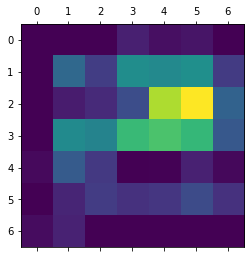

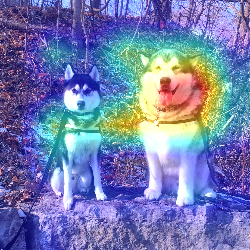

In [ ]:
Grad_CAM('husky3.jpg',layer_name='conv5_block3_add')

In [ ]:
def Grad_CAM_plus(orig,layer_name='conv5_block3_out',intensity=0.5,res=250):
  img=skimage.io.imread(orig)
  img = cv2.resize(img, (dim, dim), interpolation=cv2.INTER_NEAREST)

  x = img.astype(np.float32)
  x = np.expand_dims(x, 0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) #印出圖片的預測

  conv_layer = model.get_layer(layer_name)
  cam = models.Model([model.inputs], [conv_layer.output,model.output ])

  with tf.GradientTape() as gtape1:

      with tf.GradientTape() as gtape2:
        
          with tf.GradientTape() as gtape3:
            conv_layer,model_outs  = cam(x)
            class_out = model_outs[:, np.argmax(model_outs[0])]
            grad_1st = gtape3.gradient(class_out, conv_layer)
          grad_2nd = gtape2.gradient(grad_1st, conv_layer)
      grad_3rd = gtape1.gradient(grad_2nd, conv_layer)

  #alpha
  #分子
  alpha_num = grad_2nd[0]
  #分母
  global_sum = np.sum(conv_layer, axis=(0, 1, 2))
  alpha_denom =(2.0*alpha_num) + (global_sum*grad_3rd[0])
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom,1e-10)#np.where(condition,out1,out2)滿足condition輸出out1，不滿足輸出out2
  alpha = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alpha, axis=(0,1))
  alpha /= alpha_normalization_constant

  w = np.multiply(np.maximum(grad_1st[0], 0.0),alpha)
  w=np.sum(w,axis=(0,1))
  w[np.isnan(w)]=0.0
  heatmap = np.sum(w*conv_layer[0], axis=-1)
  heatmap = np.maximum(heatmap, 0)
  max_heat = np.max(heatmap)
  if max_heat == 0:
    max_heat = 1e-10
  heatmap /= max_heat
  tensor_summary(heatmap)
  plt.matshow(heatmap)

  #結合熱圖跟用來預測的圖片
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img = heatmap * intensity + img
  #show image.
  #cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))#原圖
  cv2_imshow(cv2.resize(img, (res, res)))



Siberian_husky


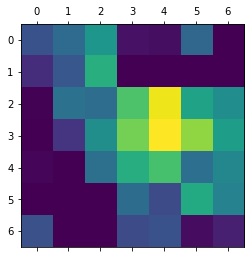

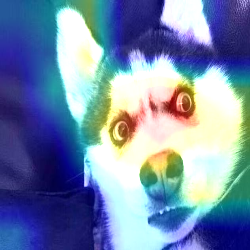

Siberian_husky
shape: (7, 7)  min: 0.0  max: 0.0


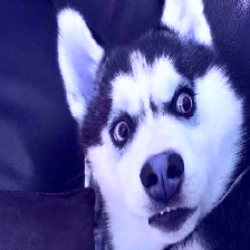

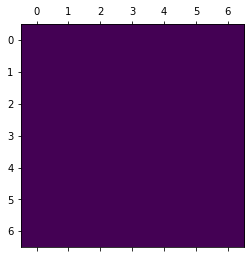

In [ ]:
Grad_CAM('husky1.jpg',layer_name='conv5_block3_add')
Grad_CAM_plus('husky1.jpg',layer_name='conv5_block3_add')

Siberian_husky


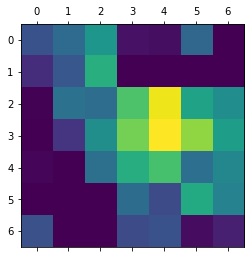

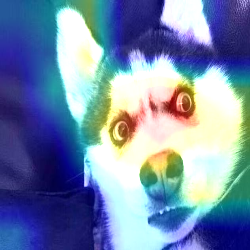

Siberian_husky
shape: (7, 7)  min: 0.0  max: 0.0


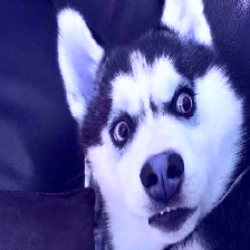

malamute


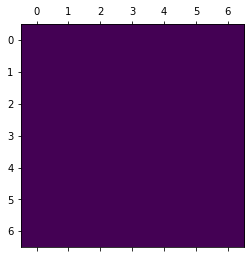

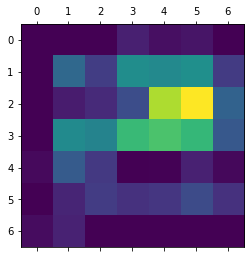

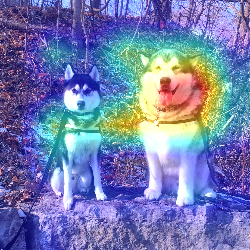

malamute
shape: (7, 7)  min: 0.0  max: 1.0


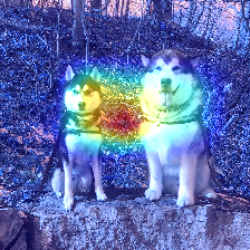

Eskimo_dog


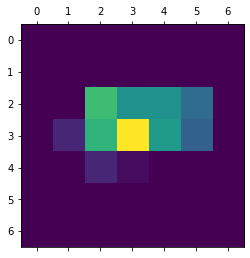

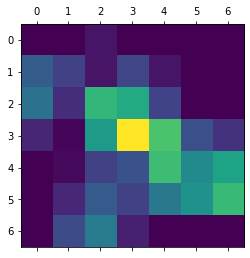

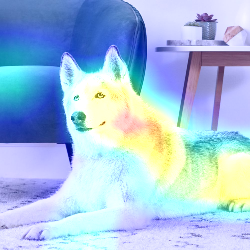

Eskimo_dog
shape: (7, 7)  min: 0.0  max: 1.0


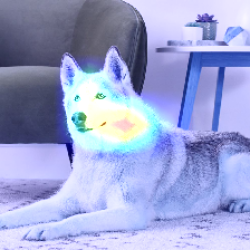

hare


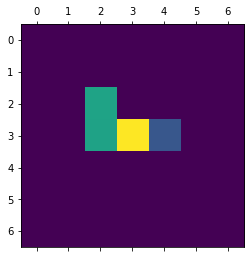

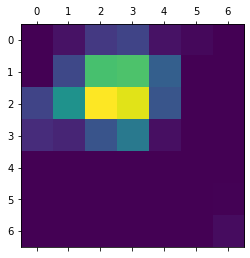

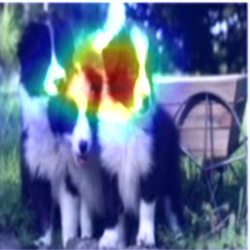

hare
shape: (7, 7)  min: 0.0  max: 1.0


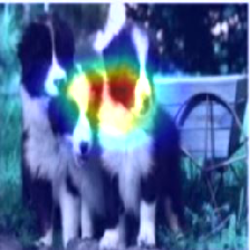

Siberian_husky


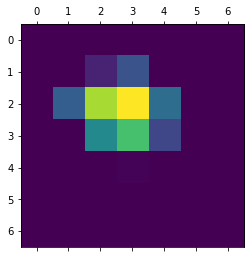

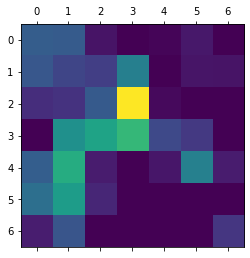

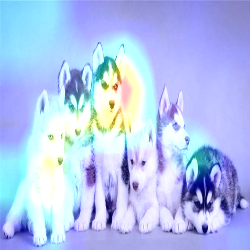

Siberian_husky
shape: (7, 7)  min: 0.0  max: 1.0


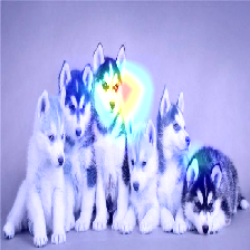

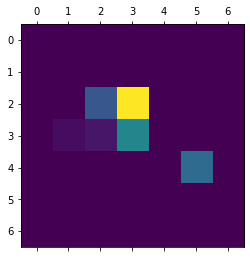

In [ ]:

Grad_CAM('husky3.jpg',layer_name='conv5_block3_add')
Grad_CAM_plus('husky3.jpg',layer_name='conv5_block3_add')
Grad_CAM('husky7.jpg',layer_name='conv5_block3_add')
Grad_CAM_plus('husky7.jpg',layer_name='conv5_block3_add')
#dog.JPG是從論文的圖片截圖下來的，測試grad-cam++寫的符不符合
Grad_CAM('dog.JPG',layer_name='conv5_block3_add')
Grad_CAM_plus('dog.JPG',layer_name='conv5_block3_add')
#多目標測試
Grad_CAM('many.jpg',layer_name='conv5_block3_add')
Grad_CAM_plus('many.jpg',layer_name='conv5_block3_add')

Siberian_husky


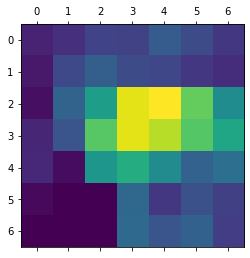

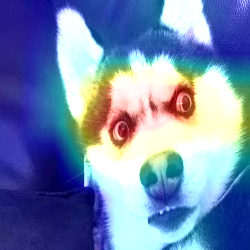

Siberian_husky
shape: (7, 7)  min: 0.0  max: 0.0


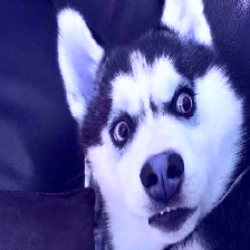

malamute


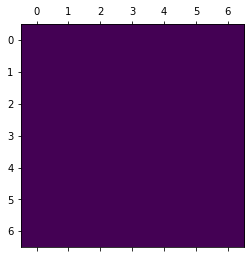

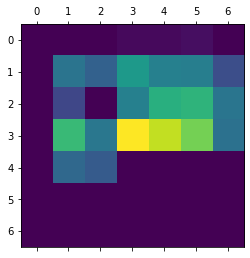

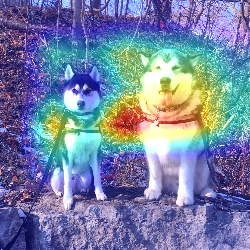

malamute
shape: (7, 7)  min: 0.0  max: 1.0


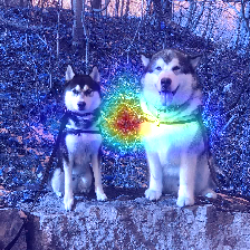

Eskimo_dog


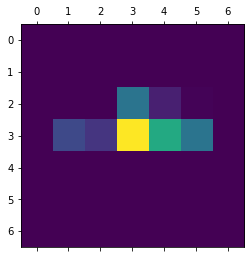

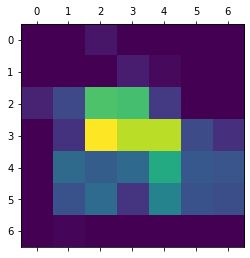

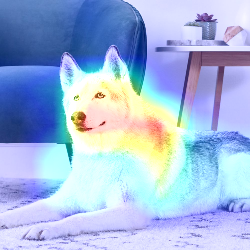

Eskimo_dog
shape: (7, 7)  min: 0.0  max: 1.0


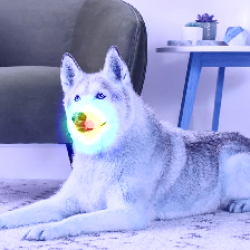

hare


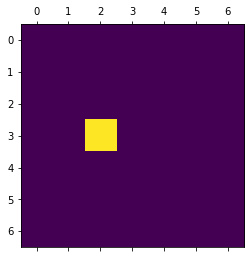

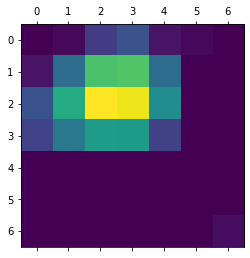

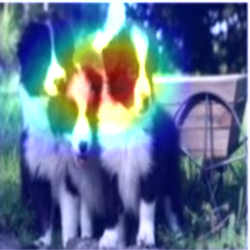

hare
shape: (7, 7)  min: 0.0  max: 1.0


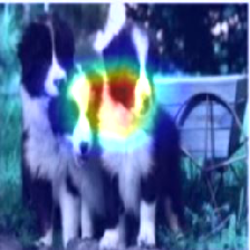

Siberian_husky


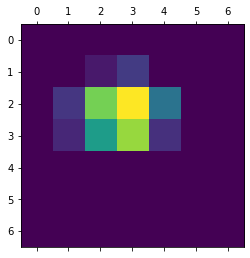

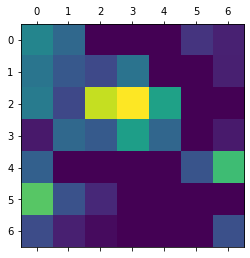

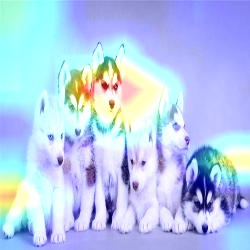

Siberian_husky
shape: (7, 7)  min: 0.0  max: 0.0


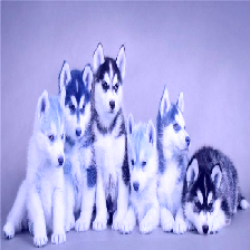

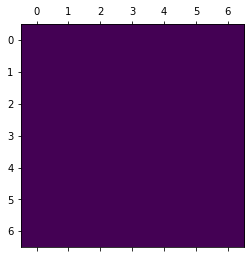

In [ ]:
Grad_CAM('husky1.jpg',layer_name='conv5_block3_3_conv')
Grad_CAM_plus('husky1.jpg',layer_name='conv5_block3_3_conv')
Grad_CAM('husky3.jpg',layer_name='conv5_block3_3_conv')
Grad_CAM_plus('husky3.jpg',layer_name='conv5_block3_3_conv')
Grad_CAM('husky7.jpg',layer_name='conv5_block3_3_conv')
Grad_CAM_plus('husky7.jpg',layer_name='conv5_block3_3_conv')
#dog.JPG是從論文的圖片截圖下來的，測試grad-cam++寫的符不符合
Grad_CAM('dog.JPG',layer_name='conv5_block3_3_conv')
Grad_CAM_plus('dog.JPG',layer_name='conv5_block3_3_conv')
#多目標測試
Grad_CAM('many.jpg',layer_name='conv5_block3_3_conv')
Grad_CAM_plus('many.jpg',layer_name='conv5_block3_3_conv')